# Run the search for dispersants using PyPAL

In [1]:
from pypal import PALCoregionalized
from pypal.models.gpr import build_coregionalized_model, predict_coregionalized, build_model, predict
from pypal.pal.utils import get_maxmin_samples, is_pareto_efficient, dominance_check_jitted_2

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import numpy as np 
import GPy

DATADIR = '../data/'

TARGETS = ['deltaGmin', 'A2_normalized']

FEATURES = [
    'num_[W]', 'max_[W]', 'num_[Tr]', 'max_[Tr]', 'num_[Ta]', 'max_[Ta]', 'num_[R]', 'max_[R]', '[W]', '[Tr]', '[Ta]',
    '[R]', 'rel_shannon', 'length'
]

In [2]:
def load_data(n_samples, label_scaling: bool = False):
    """Take in Brian's data and spit out some numpy arrays for the PAL"""
    df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
    a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
    deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values  # pylint:disable=unused-variable
    gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values * (-1)
    gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
    force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values  # pylint:disable=unused-variable
    rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
    y = np.hstack([rg.reshape(-1, 1), gibbs.reshape(-1, 1), gibbs_max.reshape(-1, 1)])
    assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

    vt = VarianceThreshold()
    X = vt.fit_transform(df_full_factorial_feat)

    feat_scaler = StandardScaler()
    X = feat_scaler.fit_transform(X)

    if label_scaling:
        label_scaler = StandardScaler()
        y = label_scaler.fit_transform(y)

    X_train, y_train, greedy_indices = get_maxmin_samples(X, y, n_samples)

    return X, y, greedy_indices

In [3]:
n_samples = 100

In [4]:
X, y, indices  = load_data(n_samples)

In [5]:
m = build_coregionalized_model(X, y, kernel=GPy.kern.RBF(X.shape[1]))

In [ ]:
m.optimize()

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [10]:
mu_0, std_0 = predict_coregionalized(m, X, 1)

In [11]:
mu_0

array([[ 7.5328034 ],
       [ 7.26780503],
       [ 6.41349458],
       ...,
       [16.36177694],
       [14.72762562],
       [16.88647858]])

In [12]:
std_0

array([[0.22812499],
       [0.22812608],
       [0.22814161],
       ...,
       [0.22805277],
       [0.22807812],
       [0.2281164 ]])

In [9]:
pareto_optimal = []
discarded = []

In [10]:
palinstance = PALCoregionalized(X, m, 3, beta_scale=1/6, epsilon=[0.05, 0.05, 0.05])

 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/pal/validate_inputs.py:146: UserWarning:No goals provided,                 will assume that every dimension should be maximized


In [11]:
palinstance.update_train_set(indices, y[indices])

In [ ]:
while sum(palinstance.unclassified):
    idx = palinstance.run_one_step()
    pareto_optimal.append(palinstance.pareto_optimal_indices)
    discarded.append(palinstance.discarded_indices)
    if idx is not None:
        palinstance.update_train_set(np.array([idx]), y[idx : idx + 1, :])
    

 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/20, f = -432.85667668355785
Optimization restart 2/20, f = -432.1124650375778
Optimization restart 3/20, f = -431.9781724223013
Optimization restart 4/20, f = -414.86786607593683
Optimization restart 5/20, f = -430.58178219461905


 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 6/20, f = -431.5053118541259
Optimization restart 7/20, f = -432.2799417444196


 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:565: RuntimeWarning:invalid value encountered in multiply
 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:568: RuntimeWarning:invalid value encountered in subtract


Optimization restart 8/20, f = -431.25490093493437
Optimization restart 9/20, f = -431.96362733989247
Optimization restart 10/20, f = -432.4582432749563
Optimization restart 11/20, f = -432.3338536415798
Optimization restart 12/20, f = -430.91802818821895
Optimization restart 13/20, f = -431.77048622140387
Optimization restart 14/20, f = -430.9032897564181
Optimization restart 15/20, f = -431.4934285883095
Optimization restart 16/20, f = -432.1556886576966
Optimization restart 17/20, f = -430.8031848468037
Optimization restart 18/20, f = -429.6846573868791
Optimization restart 19/20, f = -432.4438012139982
Optimization restart 20/20, f = -432.3829362284903
Optimization restart 1/20, f = -445.31930969878454
Optimization restart 2/20, f = -444.203033908652
Optimization restart 3/20, f = -444.5686632137766
Optimization restart 4/20, f = -444.47521654334105
Optimization restart 5/20, f = -402.67356292555655
Optimization restart 6/20, f = -443.86567630671453
Optimization restart 7/20, f = -

 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 12/20, f = -431.91061890099127
Optimization restart 13/20, f = -445.9064619375821
Optimization restart 14/20, f = -444.59120471695803
Optimization restart 15/20, f = -404.23094750968926
Optimization restart 16/20, f = -405.4376568535362
Optimization restart 17/20, f = -442.3270097097816
Optimization restart 18/20, f = -443.7501822772981
Optimization restart 19/20, f = -444.28709836466066
Optimization restart 20/20, f = -395.5449359626949
Optimization restart 1/20, f = -455.6943462323014
Optimization restart 2/20, f = -454.3807804576156
Optimization restart 3/20, f = -452.18931581700497
Optimization restart 4/20, f = -452.54632790979264
Optimization restart 5/20, f = -408.15169768267236
Optimization restart 6/20, f = -454.4086646654191
Optimization restart 7/20, f = -452.8610178355792
Optimization restart 8/20, f = -433.7070084683705
Optimization restart 9/20, f = -453.936270309805
Optimization restart 10/20, f = -407.78108156884196
Optimization restart 11/20, f = -

 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add
 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:565: RuntimeWarning:overflow encountered in multiply
 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:568: RuntimeWarning:overflow encountered in multiply
 /Users/kevinmaikjablonka/opt/miniconda3/envs/PyPal/lib/python3.7/site-packages/GPy/kern/src/stationary.py:568: RuntimeWarning:invalid value encountered in multiply


Optimization restart 15/20, f = -995.0358983395002
Optimization restart 16/20, f = -993.5916449412346
Optimization restart 17/20, f = -974.1579406875023
Optimization restart 18/20, f = -999.6480281326417
Optimization restart 19/20, f = -987.8139846387792
Optimization restart 20/20, f = -988.905233237075
Optimization restart 1/20, f = -1460.8799751314214
Optimization restart 2/20, f = -1457.3842480123656
Optimization restart 3/20, f = -1457.470467523227
Optimization restart 4/20, f = -1457.7045747178495
Optimization restart 5/20, f = -1454.1892942012782
Optimization restart 6/20, f = -1455.3081981286207
Optimization restart 7/20, f = -1446.6898143484257
Optimization restart 8/20, f = -1457.9722779585627
Optimization restart 9/20, f = -1405.6289559547995
Optimization restart 10/20, f = -1457.6571327853703
Optimization restart 11/20, f = -1424.475961780121
Optimization restart 12/20, f = -1455.532172429555
Optimization restart 13/20, f = -1455.554922061876
Optimization restart 14/20, f = 

In [12]:
palinstance.run_one_step()

Optimization restart 1/20, f = -397.4525995741062
Optimization restart 2/20, f = -432.08031729492325
Optimization restart 3/20, f = -431.6864638745508
Optimization restart 4/20, f = -432.3265893483934


 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/GPy/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/GPy/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/GPy/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/GPy/GPy/kern/src/stationary.py:565: RuntimeWarning:invalid value encountered in multiply
 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/GPy/GPy/kern/src/stationary.py:568: RuntimeWarning:invalid value encountered in subtract


Optimization restart 5/20, f = -428.39721251296083
Optimization restart 6/20, f = -431.80537690272337
Optimization restart 7/20, f = -310.6446739231654
Optimization restart 8/20, f = -431.8515692913923
Optimization restart 9/20, f = -431.44840932322063
Optimization restart 10/20, f = -428.5956533333452
Optimization restart 11/20, f = -427.4586048386241
Optimization restart 12/20, f = -431.5630146111423
Optimization restart 13/20, f = -100.1368028322018
Optimization restart 14/20, f = -431.45804974955007
Optimization restart 15/20, f = -432.71083212512906
Optimization restart 16/20, f = -396.7806144977933
Optimization restart 17/20, f = -432.033856128403
Optimization restart 18/20, f = -432.2018089846009
Optimization restart 19/20, f = -428.9973610489594
Optimization restart 20/20, f = -431.2065391384083
[[ 1.70931718e+00  2.18198739e+00  1.68680056e+00]
 [ 1.71848076e+00  3.24969484e+00  1.66722937e+00]
 [ 1.79715069e+00  3.89590752e+00  1.54311244e+00]
 [ 1.80475319e+00  4.57740789e+0

3100

In [9]:
palinstance.rectangle_lows

array([[ 1.14863896,  6.14962729,  0.51301677],
       [ 1.14827653,  6.15233763,  0.51383237],
       [ 1.14738131,  4.55524278,  0.60788165],
       ...,
       [ 1.77881329,  8.18518086, -0.64413944],
       [ 1.78074252,  7.92884703, -0.62308714],
       [ 1.78173197,  8.20339168, -0.63521432]])

In [10]:
palinstance.rectangle_ups

array([[ 1.78633956,  9.12589167,  2.93185278],
       [ 1.78814702,  9.14190633,  2.93320584],
       [ 1.78415627,  7.52470617,  3.02858972],
       ...,
       [ 3.55149948, 17.31654386,  3.24335278],
       [ 3.55259513, 17.05617682,  3.26371665],
       [ 3.55431786, 17.33500233,  3.25261992]])

In [13]:
pareto_unclassified_pessimistic_mask = is_pareto_efficient(
        -palinstance.means
    )

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

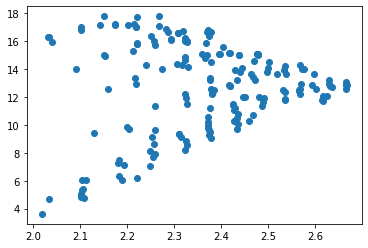

In [30]:
# plt.scatter(palinstance.means[:,0], palinstance.means[:,1], c=palinstance.means[:,2])
plt.scatter(palinstance.means[pareto_unclassified_pessimistic_mask,0], 
            palinstance.means[pareto_unclassified_pessimistic_mask,1])

In [17]:
original_indices = palinstance.unclassified_indices[pareto_unclassified_pessimistic_mask]

In [20]:
not_pareto_optimal_t = np.zeros(len(palinstance.means))
for i in range(0, len(palinstance.means)):  # pylint:disable=consider-using-enumerate
    # We can only discard points that are unclassified so far
    # We cannot discard points that are part of p_pess(P \cup U)
    if i not in original_indices:
        if dominance_check_jitted_2(
            palinstance.rectangle_lows
            + np.array([0.05, 0.05, 0.05]) * np.abs(palinstance.rectangle_ups[i]),
            palinstance.rectangle_ups[i],
        ):
            not_pareto_optimal_t[i] = True
            print('hit')

In [25]:
palinstance.rectangle_ups[2]

array([1.7832238 , 7.55760104, 3.01960815])

In [32]:
palinstance.rectangle_ups.argmin(axis=0)

array([   4,   20, 2851])

In [33]:
palinstance.rectangle_ups[4]

array([1.7711581 , 8.34162097, 2.9483989 ])

In [ ]:
dominance_check_jitted_2(r)